In [1]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

In [2]:
def resize_image(image, target_size):

    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(os.listdir(folder+label)):
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (250, 250))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [4]:
data, filenames,label, path, distribusi = insertGambar("Dataset/") 
print("Data: ", len(data))
print("Label: ", len(label))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

sampled_infeksi


100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


sampled_non_infeksi


100%|██████████| 100/100 [00:08<00:00, 11.11it/s]

Data:  200
Label:  2
Filenames:  200
Data Distribution:  {'sampled_infeksi': 100, 'sampled_non_infeksi': 100}


In [5]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()  

In [6]:
def gray_scaling(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

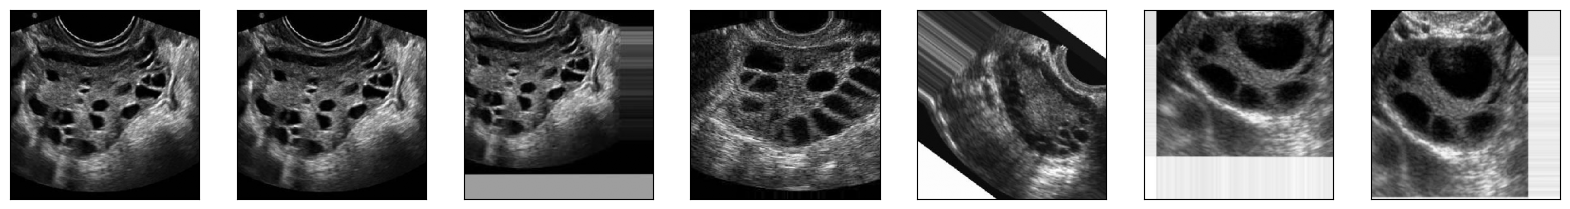

In [7]:
gray_img = gray_scaling(data)

display_sample(gray_img)

In [8]:
def median(img):
    height, width = img.shape
    kernel = np.zeros((3, 3), np.float32) / 9
    hasilMedian = np.zeros((height, width), dtype=np.uint8)
    for i in range(kernel.shape[0]//2, height-kernel.shape[0]//2):
        for j in range(kernel.shape[0]//2, width-kernel.shape[0]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                for l in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                    temp.append(img[i+k][j+l])
            temp.sort()
            median = temp[kernel.shape[0]**2//2]
            if kernel.shape[0]**2 % 2 == 0:
                median = (temp[kernel.shape[0]**2//2 - 1] + temp[kernel.shape[0]**2//2]) // 2
            else:
                median = temp[kernel.shape[0]**2//2]
            hasilMedian[i][j] = median

    return hasilMedian

def medianFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = median(img)
        hasil.append(gambar)
    return hasil

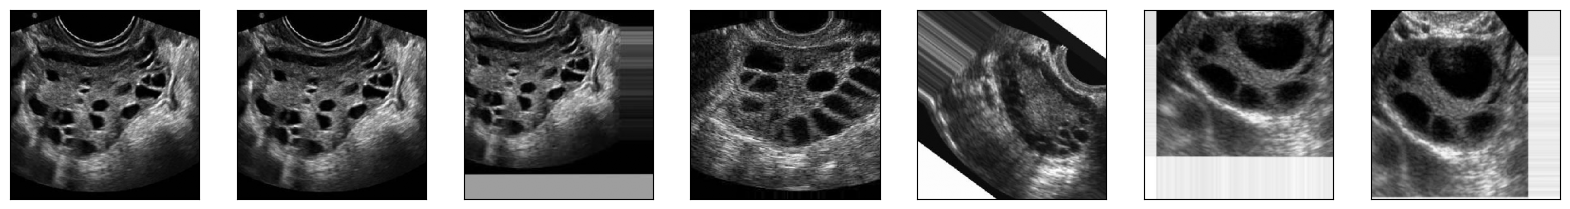

In [9]:
gray_img = gray_scaling(data)
display_sample(gray_img)

# filtered_data = medianFilterData(gray_img)
# display_sample(filtered_data)

In [10]:
def ekualisasi_histogram(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    hist = np.zeros(256, dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            hist[image[i, j]] += 1

    cdf = hist.cumsum()
    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = image.size
    cdf_normalized = ((cdf - cdf_min) / (total_pixels - cdf_min)) * 255
    cdf_normalized = cdf_normalized.astype('uint8')

    equalized_image = cdf_normalized[image]
    return equalized_image

def equalize_all_images(image_list):
    equalized_data = []
    for img in tqdm(image_list):
        eq_img = ekualisasi_histogram(img)
        equalized_data.append(eq_img)
    return equalized_data


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


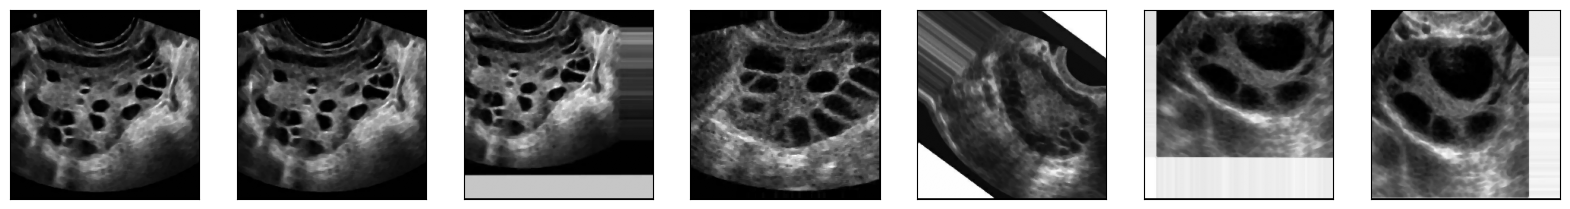

100%|██████████| 200/200 [00:08<00:00, 22.86it/s]


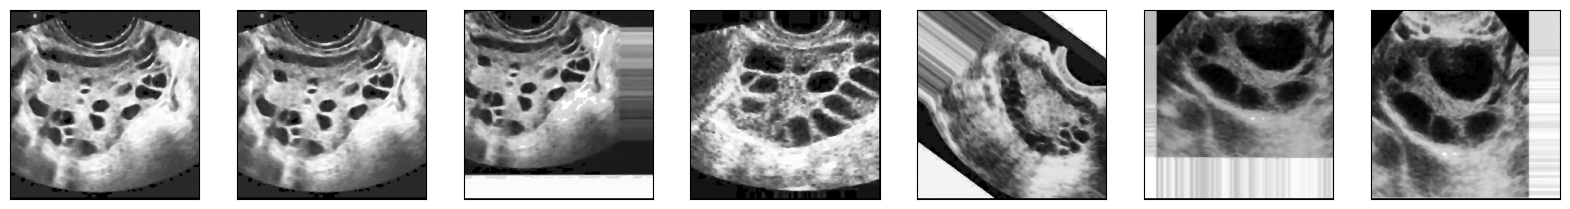

In [11]:
filtered_data = medianFilterData(gray_img)
display_sample(filtered_data)

equalized_images = equalize_all_images(filtered_data)
display_sample(equalized_images)

In [12]:
# --- Fungsi GLCM Manual & fitur ---
def glcm_manual(image, dx, dy, levels=256):
    glcm = np.zeros((levels, levels), dtype=np.float64)
    rows, cols = image.shape

    for i in range(rows - abs(dy)):
        for j in range(cols - abs(dx)):
            row = i
            col = j
            row_n = i + dy
            col_n = j + dx
            if 0 <= row_n < rows and 0 <= col_n < cols:
                intensity_current = image[row, col]
                intensity_neighbor = image[row_n, col_n]
                glcm[intensity_current, intensity_neighbor] += 1

    if glcm.sum() != 0:
        glcm /= glcm.sum()
    return glcm

def kontras(glcm):
    i, j = np.indices(glcm.shape)
    return np.sum(glcm * (i - j) ** 2)

def dissimilarity(glcm):
    i, j = np.indices(glcm.shape)
    return np.sum(glcm * np.abs(i - j))

def homogenitas(glcm):
    i, j = np.indices(glcm.shape)
    return np.sum(glcm / (1.0 + (i - j) ** 2))

def entropy(glcm):
    glcm_nonzero = glcm[glcm > 0]
    return -np.sum(glcm_nonzero * np.log(glcm_nonzero))

def asm(glcm):
    return np.sum(glcm ** 2)

def energy(glcm):
    return np.sqrt(asm(glcm))

def korelasi(glcm):
    i = np.arange(glcm.shape[0])
    j = np.arange(glcm.shape[1])
    mean_i = np.sum(i * np.sum(glcm, axis=1))
    mean_j = np.sum(j * np.sum(glcm, axis=0))
    std_i = np.sqrt(np.sum(((i - mean_i) ** 2) * np.sum(glcm, axis=1)))
    std_j = np.sqrt(np.sum(((j - mean_j) ** 2) * np.sum(glcm, axis=0)))

    numerator = 0.0
    for x in range(glcm.shape[0]):
        for y in range(glcm.shape[1]):
            numerator += (x - mean_i) * (y - mean_j) * glcm[x, y]

    denominator = std_i * std_j if std_i * std_j != 0 else 1
    return numerator / denominator

def extract_features(image):
    offsets = {
        0: (1, 0),
        45: (1, -1),
        90: (0, -1),
        135: (-1, -1)
    }

    features = []
    for angle in [0, 45, 90, 135]:
        dx, dy = offsets[angle]
        glcm = glcm_manual(image, dx, dy)
        features.extend([
            kontras(glcm),
            dissimilarity(glcm),
            homogenitas(glcm),
            entropy(glcm),
            asm(glcm),
            energy(glcm),
            korelasi(glcm)
        ])
    return features

In [13]:
def load_gray_images(image_dir):
    labels = os.listdir(image_dir)
    images = []
    labels_list = []
    for label in tqdm(labels, desc="Loading images"):
        label_path = os.path.join(image_dir, label)
        if os.path.isdir(label_path):
            image_files = os.listdir(label_path)
            for image_name in image_files:
                image_path = os.path.join(label_path, image_name)
                img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv.resize(img, (128, 128))
                    images.append(img)
                    labels_list.append(label)
    return labels_list, images


100%|██████████| 200/200 [00:02<00:00, 86.08it/s]


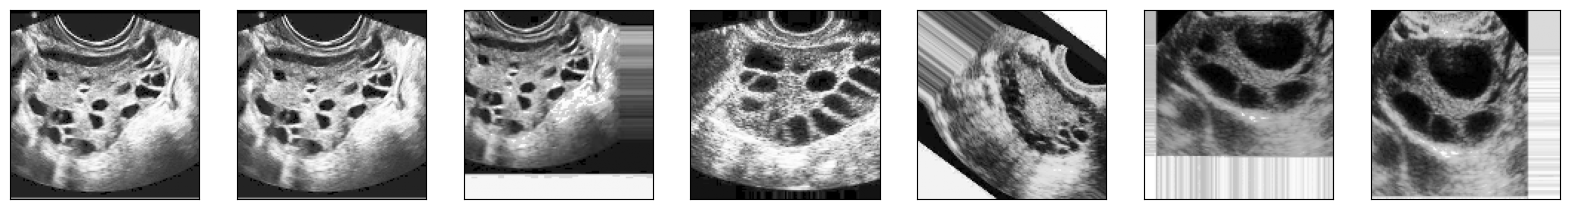

100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


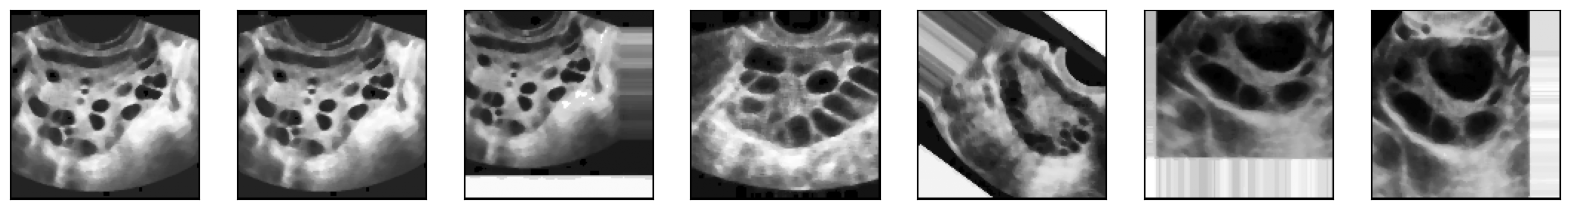

Extracting features: 100%|██████████| 200/200 [01:09<00:00,  2.89it/s]

Selesai! File 'percobaan3.csv' sudah dibuat.


In [ ]:
# Load images dan label
labels, gray_images = load_gray_images("Dataset/")



equalized_images = equalize_all_images(gray_images)
display_sample(equalized_images)
# Preprocessing
filtered_data = medianFilterData(equalized_images)
display_sample(filtered_data)

# Ekstrak fitur GLCM dari citra yang sudah diproses
result = []
for label, img in tqdm(zip(labels, filtered_data), desc="Extracting features", total=len(filtered_data)):
    features = extract_features(img)
    result.append([label] + features)

# Header untuk CSV
headers = ['label']
for angle in [0, 45, 90, 135]:
    headers.extend([f'kontras{angle}', f'dissimilarity{angle}', f'homogenitas{angle}',
                    f'entropi{angle}', f'asm{angle}', f'energi{angle}', f'correlation{angle}'])

# Simpan ke file CSV
df = pd.DataFrame(result, columns=headers)
df.to_csv('percobaan6.csv', index=False)

print("Selesai! File 'percobaan6.csv' sudah dibuat.")


In [ ]:
df = pd.read_csv('percobaan6.csv')
X = df.drop('label', axis=1)
y = df['label']

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_selected = X.drop(columns=to_drop)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

def min_max_scaling(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_train_normalized = min_max_scaling(X_train)
X_test_normalized = min_max_scaling(X_test)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_normalized, y_train)
knn_pred = knn_model.predict(X_test_normalized)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("K-Nearest Neighbors (KNN) Accuracy:", knn_accuracy)

svm_model = SVC()
svm_model.fit(X_train_normalized, y_train)
svm_pred = svm_model.predict(X_test_normalized)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine (SVM) Accuracy:", svm_accuracy)

rf_model = RandomForestClassifier()
rf_model.fit(X_train_normalized, y_train)
rf_pred = rf_model.predict(X_test_normalized)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

K-Nearest Neighbors (KNN) Accuracy: 0.975
Support Vector Machine (SVM) Accuracy: 0.925
Random Forest Accuracy: 0.875
